In [1]:
import os
import gc
import io
import gzip
import numpy as np
import pandas as pd
from seaborn import heatmap
import nibabel as nib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import tensorflow as tf
from tensorflow import data
from matplotlib.colors import ListedColormap
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Conv3D, Conv3DTranspose, MaxPooling3D, concatenate, BatchNormalization, Activation, Dropout

In [2]:
class Config():
    """
    Zbiór zmiennych globalnych i podlegająych zmianom w trakie procesu predykcji.
    """

    def __init__(self, ax=0, env='kaggle', set_size = [90, 15, 20]):
        # Oś podziału danych - 0, 1, 2
        self.ax = ax
        # Wybór środowiska
        self.env = env
        # Rozmiar wczytywanych danych, train, val, test - max 90, 15, 20
        self.set_size = set_size

        self.batch_size = 1
        # Liczba filtrów w pierwszej warstwie 
        self.filter_size_start = 32
        # Liczba filtrów w sieci neuronowej, [32, 64, 128, 256, 512]
        self.filter_size = [self.filter_size_start * 2**x for x in range(5)]
        # Rozmiar jednej części
        self.img_size = [x if i == self.ax else [256, 256, 192][i] for i, x in enumerate([48, 48, 32])]
        # Określa typ wczytywanych danych, standardowo float64 
        self.dtype = np.float32

        if self.env == 'kaggle':
            self.dataset_path = '/kaggle/input/nfbs-dataset-20/NFBS_Dataset_20'
            self.path_end = '.nii'
        elif self.env == 'laptop':
            self.dataset_path = 'NFBS_Dataset_20'
            self.path_end = '.nii.gz'



class DataNFBS():
    """
    Klasa wczytująca i przetwarzająca dane.
    Zwraca dane w formacie 'dataset' biblioteki TensorFlow, gotowe do uczenia.

    Metody
    ------
    subset_scope
        Zwraca zakresy podziału skanu na częsci
    normalization
        Wykonuje normalizację
    extract_gz
        Rozpakowanie pliku
    read_nii_file
        Przekształca dane z formatu .nii do listy
    read_dataset
        Zapisuje dane w formacie 'dataset'
    read_data
        Przekierowuje wczytanie wybranych podzbiorów
    """
    
    def __init__(self, config):
        self.config = config
        self.path = ['train', 'val', 'test']


    def subset_scope(self):
        if self.config.ax == 2:
            ranges = [(8, 40), (37, 69), (66, 98), (95, 127), (124, 156), (153, 185)]
        elif self.config.ax == 1:
            ranges = [(0, 48), (45, 93), (90, 138), (135, 183), (180, 228)]
        elif self.config.ax == 0:
            ranges = [(28, 76), (73, 121), (118, 166), (163, 211), (208, 256)]

        return ranges


    def normalization(self, data):
        # Wszystko powyżej 600 na 600
        maxx = 600
        data = np.where(data > maxx, maxx, data)
        # Dzielimy przez 600, sprowadzamy do zakresu [0, 1]
        data = data / maxx

        return data
    

    def extract_gz(self, file_path):
        # Rozpakowanie pliku .gz
        with gzip.open(file_path, 'rb') as f_in:
            file_content = f_in.read()
        
        # Wczytanie danych z rozpakowanego strumienia
        file_stream = io.BytesIO(file_content)
        img = nib.Nifti1Image.from_bytes(file_stream.getvalue())   

        return img


    def read_nii_file(self, file_path, data):
        # jeśli wczytujemy plik na laptopie to musimy go najpierw rozpakować a dopiero potem wczytać
        if self.config.env == 'laptop':
            img = self.extract_gz(file_path)
        # jeśli wczytujemy plik z kaggle to jest on już rozpakowany, od razu możemy wczytać
        elif self.config.env == 'kaggle':
            img = nib.load(file_path)

        # img to wewnętrzny typ nibabel, wyciągamy dane i konwertujemy do określonego typu
        # scan to czyste dane [256, 256, 192]
        scan = img.dataobj[:, :, :].astype(self.config.dtype)

        # normalizacja, jeśli to nie jest maska
        if 'mask' not in file_path:
            scan = self.normalization(scan)

        # zapisujemy po kawałkach
        ranges = self.subset_scope()

        for a, b in ranges:
            if self.config.ax == 2:
                data.append(scan[:, :, a:b])
            elif self.config.ax == 1:
                data.append(scan[:, a:b, :])
            elif self.config.ax == 0:
                data.append(scan[a:b, :, :])

        return data


    def read_dataset(self, pos):
            # position zawiera nazwę pozbioru
            position = self.path.index(pos)
            X_data = []
            y_data = [] # maska

            # pobieramy wszystkie nazwy plików z folderu podzbioru
            files = os.listdir(self.config.dataset_path + '/' + self.path[position])
            # sortujemy pliki po indeksie, który jest na pozycji 5:8
            files_sort = sorted(set([x[5:8] for x in files]))

            # wczytujemy X pierwszych plików
            for i in range(self.config.set_size[position]):
                X_data = self.read_nii_file(f"{self.config.dataset_path}/{self.path[position]}/NFBS_{str(files_sort[i])}_{self.path[position]}{self.config.path_end}", X_data)
                y_data = self.read_nii_file(f"{self.config.dataset_path}/{self.path[position]}/NFBS_{str(files_sort[i])}_mask_{self.path[position]}{self.config.path_end}", y_data)

            # zmieniam listę w której są 3 wymiarowe dane na 4 wymiarowe dane 
            X_data = np.stack(X_data, axis=0)
            y_data = np.stack(y_data, axis=0)

            # tworzę dataset
            # prefetch przygotowuje kolejne partie danych w tle, dzięki temu model nie musi czekać na załadowanie kolejnych danych w trakcie treningu
            # repeat powiela dane, umozliwiając trenowanie na więcej niż jednej eopoce
            train_dataset = data.Dataset.from_tensor_slices((X_data, y_data)).batch(self.config.batch_size).prefetch(data.AUTOTUNE).repeat()
            del X_data, y_data
            gc.collect()

            return train_dataset


    def read_data(self, status):
        # Wczytuje tylko podzbiór uczący
        if status == 'train':
            return self.read_dataset('train')
        # Wczytuje tylko podzbiór walidacyjny
        elif status == 'val':
            return self.read_dataset('val')
        # Wczytuje tylko podzbiór testowy
        elif status == 'test':
            return self.read_dataset('test')
        else:
            print("Popraw.")


class UNetModel3D():
    """
    Architektura modelu
    """
    
    def __init__(self, config):
        self.config = config
        self.activation = 'relu'

    def conv_block(self, inp, filters):
        x = Conv3D(filters, (3, 3, 3), padding='same')(inp)
        x = BatchNormalization(axis=4)(x)
        x = Activation(self.activation)(x)
        x = Conv3D(filters, (3, 3, 3), padding='same')(x)
        x = BatchNormalization(axis=4)(x)
        x = Activation(self.activation)(x)
        return x

    def encoder_block(self, inp, filters):
        x = self.conv_block(inp, filters)
        p = MaxPooling3D(pool_size=(2, 2, 2))(x)
        # x - to ta długa strzałka w bok
        return x, p

    def decoder_block(self, inp, filters, concat):  # concat to od strzałki (x)
        x = Conv3DTranspose(filters, (3, 3, 3), strides=(2, 2, 2), padding='same')(inp)
        x = BatchNormalization(axis=4)(x)
        x = Activation(self.activation)(x)
        x = concatenate([x, concat])
        x = self.conv_block(x, filters)
        return x

    def create_model(self):
        inputs = Input((self.config.img_size[0], self.config.img_size[1], self.config.img_size[2], 1)) # 1 bo tylko odcień szarości

        x1, p1 = self.encoder_block(inputs, self.config.filter_size[0])
        x2, p2 = self.encoder_block(p1, self.config.filter_size[1])
        x3, p3 = self.encoder_block(p2, self.config.filter_size[2])
        x4, p4 = self.encoder_block(p3, self.config.filter_size[3])

        mid = self.conv_block(p4, self.config.filter_size[4])
        mid = Dropout(0.2)(mid)

        y1 = self.decoder_block(mid, self.config.filter_size[3], x4)
        y2 = self.decoder_block(y1, self.config.filter_size[2], x3)
        y3 = self.decoder_block(y2, self.config.filter_size[1], x2)
        y4 = self.decoder_block(y3, self.config.filter_size[0], x1)

        outputs = Conv3D(1, (1, 1, 1), activation='sigmoid')(y4)

        model = Model(inputs=inputs, outputs=outputs)

        print('Całkowita liczba parametrów: {:,}'.format(model.count_params()))

        return model

In [3]:
class PredWhole():
    """
    Klasa obliczająca metryki dla predykcji.
    Oblicza predykcję trzech modeli i scala w model łączony.

    
    Metody
    -------
    pred
        Zarządza wykonywaniem funkcji, przpeorwadza proces głosowania
    calculate_pred
        Oblicza predykcję jednego modelu
    read_gz_nii_file
        Wczytuje maski
    read_masks
        Zapisuje maski do listy
    calculate_metrics
        Oblicza metryki dla całego skanu
    calculate_metrics_extended
        Oblicza metryki skanów w podziale na plastry
    calculate_FP_FN
        Oblicza macierz pomyłek osobno dla każdej osi
    calculate_extended_matrix
        Zlicza woksele w podziale według głosowania
    """

    def __init__(self, set_size, env='kaggle'):
        assert set_size[0] <= 90, "Za duży rozmiar 'set_size', max 90"
        assert set_size[1] <= 15, "Za duży rozmiar 'set_size', max 15"
        assert set_size[2] <= 20, "Za duży rozmiar 'set_size', max 20"
        self.set_size = set_size

        # Zwróci pozycję 0, 1 lub 2
        self.pos = [i for i, x in enumerate(self.set_size) if x != 0][0]
        # Zwróci nazwę zbioru z którego chcemy wczytać skany
        self.current_set = ['train', 'val', 'test'][self.pos]
        # Pierwsze numeracje plików kolejno dla: train, val, test
        self.start = [1, 91, 106][self.pos]
        
        # Wybór środowiska w którym uruchamiamy kod
        self.env = env
        if self.env == 'kaggle':
            self.dataset_path = '/kaggle/input/nfbs-dataset-20/NFBS_Dataset_20'
            self.path_end = '.nii'
            self.load_path = '/kaggle/input/modele/'
            self.test_stats = pd.read_csv('/kaggle/input/nfbs-test-stats/NFBS_test_stats.csv', sep=';')
        elif self.env == 'laptop':
            self.dataset_path = 'NFBS_Dataset_20'
            self.path_end = '.nii.gz'
            self.load_path = 'Modele/'
            self.test_stats = pd.read_csv('NFBS_test_stats.csv', sep=';')
            
            
    def pred(self):
        self.y_pred_0_whole = self.calculate_pred(ax=0) # Model czołowy
        self.y_pred_1_whole = self.calculate_pred(ax=1) # Model poprzeczny
        self.y_pred_2_whole = self.calculate_pred(ax=2) # Model strzałkowy
        
        # Etap głosowania
        self.y_pred_all = tf.cast(tf.math.greater((self.y_pred_0_whole + self.y_pred_1_whole + self.y_pred_2_whole), 1), 'int8')

        self.read_masks()
        self.calculate_metrics()
        # self.calculate_metrics_extended()
        # self.calculate_FP_FN()
        # self.calculate_extended_matrix()
        tf.compat.v1.reset_default_graph
        gc.collect()
        print('Koniec')

        
    def calculate_pred(self, ax):
        # Zwróci liczbę kawałków na jakie został podzielony dataset zgodnie z podaną osią
        number_of_pieces= [5, 5, 6][ax]
        # Zwróci nazwę modelu zgodnie z podaną osią
        model_name = ['K_0_32_NFBS-20_48_FT-21.weights.h5',
                      'K_1_32_NFBS-20_48_TR-48.weights.h5',
                      'K_2_32_NFBS-20_32_TR-60.weights.h5'][ax]

        # -----

        config = Config(ax = ax, 
                        env = self.env, 
                        set_size = self.set_size)

        # pobierz określony dataset
        dataset = DataNFBS(config).read_data(self.current_set)

        model = UNetModel3D(config).create_model()
        
        # Wczytaj wagi modeu
        model.load_weights(self.load_path + model_name)
        # Dokonaj predykcji
        y_pred = model.predict(dataset.take(self.set_size[self.pos] * number_of_pieces), batch_size=config.batch_size, verbose=1).astype(np.float16)

        # Rzutowanie na 0 lub 1
        y_pred_0_1 = tf.cast(tf.math.greater(y_pred, 0.5), 'int8')
        y_pred_whole = np.zeros((self.set_size[self.pos], 256, 256, 192), dtype=np.int8)

        # Łączenie częsci w jeden skan
        for i in range(self.set_size[self.pos]):
            if ax == 0:
                # [(28, 76), (73, 121), (118, 166), (163, 211), (208, 256)]
                y_pred_whole[i,    0:28, :, :] = 0
                y_pred_whole[i,   28:73, :, :] = y_pred_0_1[i * 5 + 0, 0:45, :, :, 0]
                y_pred_whole[i,  73:121, :, :] = y_pred_0_1[i * 5 + 1, 0:48, :, :, 0]
                y_pred_whole[i, 121:166, :, :] = y_pred_0_1[i * 5 + 2, 3:48, :, :, 0]
                y_pred_whole[i, 166:211, :, :] = y_pred_0_1[i * 5 + 3, 3:48, :, :, 0]
                y_pred_whole[i, 211:256, :, :] = y_pred_0_1[i * 5 + 4, 3:48, :, :, 0]
            elif ax == 1:
                # [(0, 48), (45, 93), (90, 138), (135, 183), (180, 228)]
                y_pred_whole[i, :,    0:45, :] = y_pred_0_1[i * 5 + 0, :, 0:45, :, 0]
                y_pred_whole[i, :,   45:93, :] = y_pred_0_1[i * 5 + 1, :, 0:48, :, 0]
                y_pred_whole[i, :,  93:138, :] = y_pred_0_1[i * 5 + 2, :, 3:48, :, 0]
                y_pred_whole[i, :, 138:183, :] = y_pred_0_1[i * 5 + 3, :, 3:48, :, 0]
                y_pred_whole[i, :, 183:228, :] = y_pred_0_1[i * 5 + 4, :, 3:48, :, 0]
                y_pred_whole[i, :, 228:256, :] = 0
            else:
                # [(8, 40), (37, 69), (66, 98), (95, 127), (124, 156), (153, 185)]
                y_pred_whole[i, :, :,     0:8] = 0
                y_pred_whole[i, :, :,    8:37] = y_pred_0_1[i * 6 + 0, :, :, 0:29, 0]
                y_pred_whole[i, :, :,   37:69] = y_pred_0_1[i * 6 + 1, :, :, 0:32, 0]
                y_pred_whole[i, :, :,   69:98] = y_pred_0_1[i * 6 + 2, :, :, 3:32, 0]
                y_pred_whole[i, :, :,  98:127] = y_pred_0_1[i * 6 + 3, :, :, 3:32, 0]
                y_pred_whole[i, :, :, 127:156] = y_pred_0_1[i * 6 + 4, :, :, 3:32, 0]
                y_pred_whole[i, :, :, 156:185] = y_pred_0_1[i * 6 + 5, :, :, 3:32, 0]
                y_pred_whole[i, :, :, 185:192] = 0

        # Usuwam referencję do obiektu
        dataset = None
        del y_pred, y_pred_0_1
        gc.collect()

        return y_pred_whole


    def read_gz_nii_file(self, file_path):
        # Rozpakowanie pliku .gz
        if self.env == 'laptop':
            with gzip.open(file_path, 'rb') as f_in:
                file_content = f_in.read()

            # Wczytanie danych z rozpakowanego strumienia
            file_stream = io.BytesIO(file_content)
            img = nib.Nifti1Image.from_bytes(file_stream.getvalue())   
        # jeśli wczytujemy plik z kaggle to jest on już rozpakowany, od razu możemy wczytać
        elif self.env == 'kaggle':
            img = nib.load(file_path)
        
        # Ekstrakcja danych z wybranego zakresu i konwersja do uint8, bo tylko 0 i 1
        data = img.dataobj[:, :, :].astype(np.int8)

        return data
    
    
    def read_masks(self):
        self.masks = []
        for i in range(self.set_size[self.pos]):
            file = self.dataset_path + '/' + self.current_set + '/' + 'NFBS_' + str(self.start + i).zfill(3) + '_mask_' + self.current_set + self.path_end
            self.masks.append(self.read_gz_nii_file(file))

        self.masks = np.stack(self.masks, axis=0)
        
        
    def calculate_metrics(self):
        self.metrics = np.zeros((self.set_size[self.pos], 4, 4))
        self.dice = np.zeros((self.set_size[self.pos], 4))
        self.jaccard = np.zeros((self.set_size[self.pos], 4))
        self.sensitivity = np.zeros((self.set_size[self.pos], 4))
        self.specificity = np.zeros((self.set_size[self.pos], 4))

        for j, elem in enumerate([self.y_pred_all, self.y_pred_0_whole, self.y_pred_1_whole, self.y_pred_2_whole]):
#         for j, elem in enumerate([self.y_pred_2_whole]):
            for i in range(self.set_size[self.pos]):
                y_true = self.masks[i, :, :, :] 
                y_pred = elem[i, :, : , :]
                
                TP = np.where((y_true + y_pred) == 2, 1, 0).sum()
                FP = np.where((y_true - y_pred) == -1, 1, 0).sum()
                FN = np.where((y_true - y_pred) == 1, 1, 0).sum()
                TN = np.where((y_true + y_pred) == 0, 1, 0).sum()
                
                self.metrics[i, j] = [TP, FP, FN, TN]
                self.dice[i, j] = 2*TP / (2*TP + FP + FN)
                self.jaccard[i, j] = TP / (TP + FP + FN)
                self.sensitivity[i, j] = TP / (FN + TP)
                self.specificity[i, j] = TN / (TN + FP)
                
            del y_true, y_pred
            
            
    def calculate_metrics_extended(self):
        self.metrics_ext = np.zeros((self.set_size[self.pos], 4, 192, 4))
        self.dice_ext = np.zeros((self.set_size[self.pos], 4, 192))
        self.jaccard_ext = np.zeros((self.set_size[self.pos], 4, 192))
        self.sensitivity_ext = np.zeros((self.set_size[self.pos], 4, 192))
        self.specificity_ext = np.zeros((self.set_size[self.pos], 4, 192))
        
        for j, elem in enumerate([self.y_pred_all, self.y_pred_0_whole, self.y_pred_1_whole, self.y_pred_2_whole]):
#         for j, elem in enumerate([self.y_pred_2_whole]):
            for i in range(self.set_size[self.pos]):
                for k in range(192):
                    y_true = self.masks[i, :, :, k] 
                    y_pred = elem[i, :, : , k]

                    TP = np.where((y_true + y_pred) == 2, 1, 0).sum()
                    FP = np.where((y_true - y_pred) == -1, 1, 0).sum()
                    FN = np.where((y_true - y_pred) == 1, 1, 0).sum()
                    TN = np.where((y_true + y_pred) == 0, 1, 0).sum()

                    self.metrics_ext[i, j, k] = [TP, FP, FN, TN]
                    self.dice_ext[i, j, k] = 2*TP / (2*TP + FP + FN + 1)
                    self.jaccard_ext[i, j, k] = TP / (TP + FP + FN)
                    self.sensitivity_ext[i, j, k] = TP / (FN + TP + 1)
                    self.specificity_ext[i, j, k] = TN / (TN + FP + 1)
                
        del y_true, y_pred
        
        
    def calculate_FP_FN(self):
        # liczę macierz pomyłek osobno dla każdej osi
        
        self.metrics_ext_FP_FN_0 = np.zeros((self.set_size[self.pos], 4, 256, 4))
        self.metrics_ext_FP_FN_1 = np.zeros((self.set_size[self.pos], 4, 256, 4))
        self.metrics_ext_FP_FN_2 = np.zeros((self.set_size[self.pos], 4, 192, 4))
        
#         for j, elem in enumerate([self.y_pred_all, self.y_pred_0_whole, self.y_pred_1_whole, self.y_pred_2_whole]):
        for j, elem in enumerate([self.y_pred_all]):
            for i in range(self.set_size[self.pos]):
                # czołowa
                for k in range(256):
                    y_true = self.masks[i, k, :, :] 
                    y_pred = elem[i, k, :, :]

                    TP = np.where((y_true + y_pred) == 2, 1, 0).sum()
                    FP = np.where((y_true - y_pred) == -1, 1, 0).sum()
                    FN = np.where((y_true - y_pred) == 1, 1, 0).sum()
                    TN = np.where((y_true + y_pred) == 0, 1, 0).sum()

                    self.metrics_ext_FP_FN_0[i, j, k] = [TP, FP, FN, TN]
                
                # poprzeczna
                for k in range(256):
                    y_true = self.masks[i, :, k, :] 
                    y_pred = elem[i, :, k, :]

                    TP = np.where((y_true + y_pred) == 2, 1, 0).sum()
                    FP = np.where((y_true - y_pred) == -1, 1, 0).sum()
                    FN = np.where((y_true - y_pred) == 1, 1, 0).sum()
                    TN = np.where((y_true + y_pred) == 0, 1, 0).sum()

                    self.metrics_ext_FP_FN_1[i, j, k] = [TP, FP, FN, TN]
                
                # strzałkowa
                for k in range(192):
                    y_true = self.masks[i, :, :, k] 
                    y_pred = elem[i, :, :, k]

                    TP = np.where((y_true + y_pred) == 2, 1, 0).sum()
                    FP = np.where((y_true - y_pred) == -1, 1, 0).sum()
                    FN = np.where((y_true - y_pred) == 1, 1, 0).sum()
                    TN = np.where((y_true + y_pred) == 0, 1, 0).sum()

                    self.metrics_ext_FP_FN_2[i, j, k] = [TP, FP, FN, TN]
                
        del y_true, y_pred
    
                                    
    def calculate_extended_matrix(self):
        self.extended_head = np.zeros((self.set_size[self.pos], 256, 256, 192), dtype=np.int8)
        self.extended_head = self.y_pred_0_whole * 2 + self.y_pred_1_whole * 3 + self.y_pred_2_whole * 4
        self.extended_head = np.where(self.extended_head == 9, 8, self.extended_head)
        self.extended_head = np.where(self.extended_head == 0, 1, self.extended_head)
        self.extended_head = self.extended_head * np.where(self.masks == 1, 1, -1)

        self.extended_matrix = np.zeros((self.set_size[self.pos], 8, 2))

        for i in range(self.set_size[self.pos]):                 
            self.extended_matrix[i, 0, 0] = np.where(self.extended_head[i] == 8, 1, 0).sum()
            self.extended_matrix[i, 1, 0] = np.where(self.extended_head[i] == 7, 1, 0).sum()
            self.extended_matrix[i, 2, 0] = np.where(self.extended_head[i] == 6, 1, 0).sum()
            self.extended_matrix[i, 3, 0] = np.where(self.extended_head[i] == 5, 1, 0).sum()
            self.extended_matrix[i, 4, 0] = np.where(self.extended_head[i] == 4, 1, 0).sum()
            self.extended_matrix[i, 5, 0] = np.where(self.extended_head[i] == 3, 1, 0).sum()
            self.extended_matrix[i, 6, 0] = np.where(self.extended_head[i] == 2, 1, 0).sum()
            self.extended_matrix[i, 7, 0] = np.where(self.extended_head[i] == 1, 1, 0).sum()

            self.extended_matrix[i, 0, 1] = np.where(self.extended_head[i] == -8, 1, 0).sum()
            self.extended_matrix[i, 1, 1] = np.where(self.extended_head[i] == -7, 1, 0).sum()
            self.extended_matrix[i, 2, 1] = np.where(self.extended_head[i] == -6, 1, 0).sum()
            self.extended_matrix[i, 3, 1] = np.where(self.extended_head[i] == -5, 1, 0).sum()
            self.extended_matrix[i, 4, 1] = np.where(self.extended_head[i] == -4, 1, 0).sum()
            self.extended_matrix[i, 5, 1] = np.where(self.extended_head[i] == -3, 1, 0).sum()
            self.extended_matrix[i, 6, 1] = np.where(self.extended_head[i] == -2, 1, 0).sum()
            self.extended_matrix[i, 7, 1] = np.where(self.extended_head[i] == -1, 1, 0).sum()

In [4]:
def show_metrics(pred_whole):
    """
    Wyświetl porównanie metryk w podziale na modele
    """

    metrics = ['Dice', 'Jaccard', 'Czułość', 'Specyficzność']
    modele = ['Łączony', 'Czołowy', 'Poprzeczny', 'Strzałkowy']

    fig, ax = plt.subplots(1, 4, figsize=(16, 3))

    ax[0].bar(modele, np.mean(pred_whole.dice, axis=0))
    ax[0].set_ylim(0.97, 1)
    ax[0].set_title(metrics[0])
    ax[0].set_xticks(range(len(modele)))
    ax[0].set_xticklabels(modele, rotation=20)

    ax[1].bar(modele, np.mean(pred_whole.jaccard, axis=0))
    ax[1].set_ylim(0.92, 1)
    ax[1].set_title(metrics[1])
    ax[1].set_xticks(range(len(modele)))
    ax[1].set_xticklabels(modele, rotation=20)

    ax[2].bar(modele, np.mean(pred_whole.sensitivity, axis=0))
    ax[2].set_ylim(0.97, 1)
    ax[2].set_title(metrics[2])
    ax[2].set_xticks(range(len(modele)))
    ax[2].set_xticklabels(modele, rotation=20)

    ax[3].bar(modele, np.mean(pred_whole.specificity, axis=0))
    ax[3].set_ylim(0.995, 1)
    ax[3].set_title(metrics[3])
    ax[3].set_xticks(range(len(modele)))
    ax[3].set_xticklabels(modele, rotation=20)      
        
    plt.show()

In [14]:
def create_dice_heatmap(pred_whole):
    """
    Stwórz mapę ciepła
    """

    if pred_whole.current_set == 'test':
        dataa = np.hstack((pred_whole.dice, pred_whole.test_stats.Dice[:pred_whole.set_size[pred_whole.pos]].to_numpy().reshape(pred_whole.set_size[pred_whole.pos], 1))).T
        dataa = np.hstack((dataa, np.empty((5, 1)) * np.nan, np.mean(dataa, axis=1).reshape(5, 1)))
        y_label = ['Łączony', 'Czołowy', 'Poprzeczny', 'Strzałkowy', 'Artykuł']
    else:
        dataa = pred_whole.dice.T
        y_label = ['Łączony', 'Czołowy', 'Poprzeczny', 'Strzałkowy']
        

        
    x_label = list(np.arange(pred_whole.set_size[pred_whole.pos]) + pred_whole.start)
    x_label.append('')
    x_label.append('Średnia')

    width = pred_whole.set_size[pred_whole.pos] + 2
        
    plt.figure(figsize=(width, 3.5), dpi=100)
    heatmap(dataa, 
            annot=True, 
            fmt='.3f', 
            cmap='viridis', 
            annot_kws={'size': 10},
            yticklabels=y_label,
            xticklabels=x_label,
            vmin=0.975,  # Minimalna wartość dla skali kolorów, ustalono na podstawie zbioru testowego
            vmax=0.992   # Maksymalna wartość dla skali kolorów, ustalono na podstawie zbioru testowego
            )

    plt.yticks(rotation=45)

    plt.title(f"Heatmap - dice - {pred_whole.current_set}")
    plt.xlabel('Numer skanu')
    plt.ylabel('Model')
    plt.show()

In [6]:
def read_gz_nii_file(filepath):
    # Rozpakowanie pliku .gz do strumienia w pamięci
    with gzip.open(filepath, 'rb') as f_in:
        file_content = f_in.read()
    
    # Wczytanie danych z rozpakowanego strumienia
    file_stream = io.BytesIO(file_content)
    img = nib.Nifti1Image.from_bytes(file_stream.getvalue())
    
    # Ekstrakcja danych z wybranego zakresu i konwersja do uint16
    data = img.dataobj[:, :, :].astype(np.uint16)

    return data

In [7]:
def show_comparison(pred_whole, set_size, nr, no_slice):
    """"
    Wyświetla oryginalna maskę i maske predykcji, porównuje maski    
    """

    # warunki
    assert nr < set_size[pred_whole.pos], f'Wyszedłeś poza zakres wczytanych plików, wybierz z zakresu: 0-{set_size[pred_whole.pos]-1}'
    assert no_slice < 192, 'Wyszedłeś poza zakres osi, wybierz z zakresu: 0-191'

    head = read_gz_nii_file(f'NFBS_Dataset_20/{pred_whole.current_set}/NFBS_{str(pred_whole.start + nr).zfill(3)}_{pred_whole.current_set}.nii.gz')
    mask = read_gz_nii_file(f'NFBS_Dataset_20/{pred_whole.current_set}/NFBS_{str(pred_whole.start + nr).zfill(3)}_mask_{pred_whole.current_set}.nii.gz')

    mask = np.fliplr(mask[:, :, no_slice].T)
    mask = np.where(mask == 1, mask, np.nan)

    mask_pred = np.fliplr(pred_whole.y_pred_all[nr, :, :, no_slice].numpy().T)
    mask_pred = np.where(mask_pred == 1, mask_pred, np.nan)

    cmap_mask = ListedColormap(['#2ba2aa'])


    plt.figure(figsize=(18, 6))

    ax1 = plt.subplot(131)
    ax1.imshow(np.fliplr(head[:, :, no_slice].T), cmap='gray')
    ax1.imshow(mask, cmap=cmap_mask, alpha=0.6)
    ax1.set_title('Maska oryginalna')

    ax2 = plt.subplot(132)
    ax2.imshow(np.fliplr(head[:, :, no_slice].T), cmap='gray')
    ax2.imshow(mask_pred, cmap=cmap_mask, alpha=0.6)
    ax2.set_title('Maska z predykcji')

    ax3 = plt.subplot(133)
    ax3.imshow(np.where(~np.isnan(mask_pred) & np.isnan(mask), mask_pred, np.nan), interpolation='nearest', cmap=ListedColormap(['#FF0000']))
    patch1 = mpatches.Patch(color='#FF0000', label='FP') # Nie powinno być maski, ale jest
    ax3.imshow(np.where(~np.isnan(mask_pred) & ~np.isnan(mask), mask_pred, np.nan), interpolation='nearest', cmap=ListedColormap(['#00FF00']), alpha=0.4)
    patch2 = mpatches.Patch(color='#00FF00', label='TP') # Część wspólna
    ax3.imshow(np.where(np.isnan(mask_pred) & ~np.isnan(mask), mask, np.nan), interpolation='nearest', cmap=ListedColormap(['#0000FF']))
    patch3 = mpatches.Patch(color='#0000FF', label='FN') # Powinna być maska, ale nie ma
    ax3.legend(handles=[patch1, patch2, patch3], loc='upper right')
    ax3.set_title('Porównanie')

    plt.show()

___

In [8]:
# Na własnym sprzecie dla test_set_size = [0, 0, 2] program wykonuje się około 2 minuty
# Nie zalecam pobierać więcej niż 3 skanów, chyba że ma się dużo wolnej pamięci RAM
test_set_size = [0, 0, 2]

pred_whole = PredWhole(test_set_size, env='laptop')
pred_whole.pred()

Całkowita liczba parametrów: 25,896,545
10/10 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step
Całkowita liczba parametrów: 25,896,545
10/10 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step
Całkowita liczba parametrów: 25,896,545
12/12 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step

Koniec


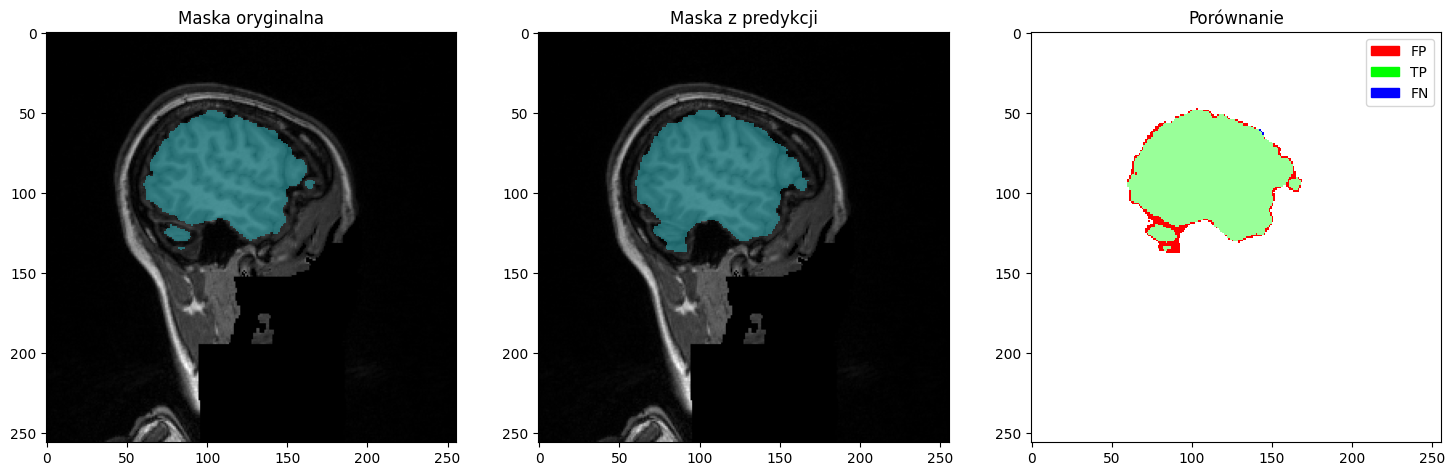

In [9]:
# nr - numer skanu (liczone od zera)
# no_slice - numer plastra w osi strzałkowej (liczone od zera)

show_comparison(pred_whole, test_set_size, nr=0, no_slice=46)

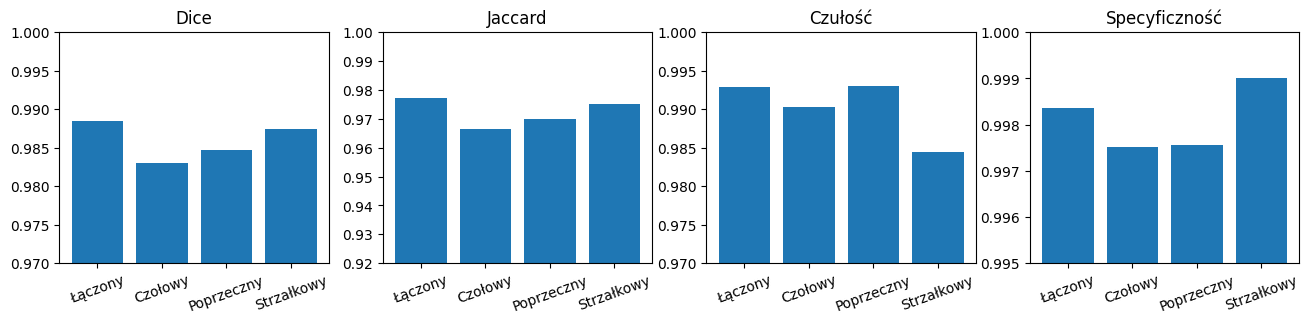

In [10]:
show_metrics(pred_whole)

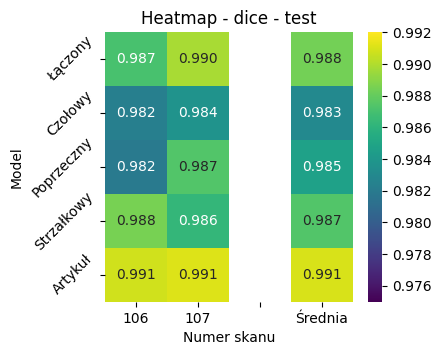

In [15]:
create_dice_heatmap(pred_whole)